# Section 1 - Simple Sparse Signal Recovery

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct
from PIL import Image
from skimage.color import rgb2gray
from skimage import data

## Section 1.1 -  A sparse time-domain signal

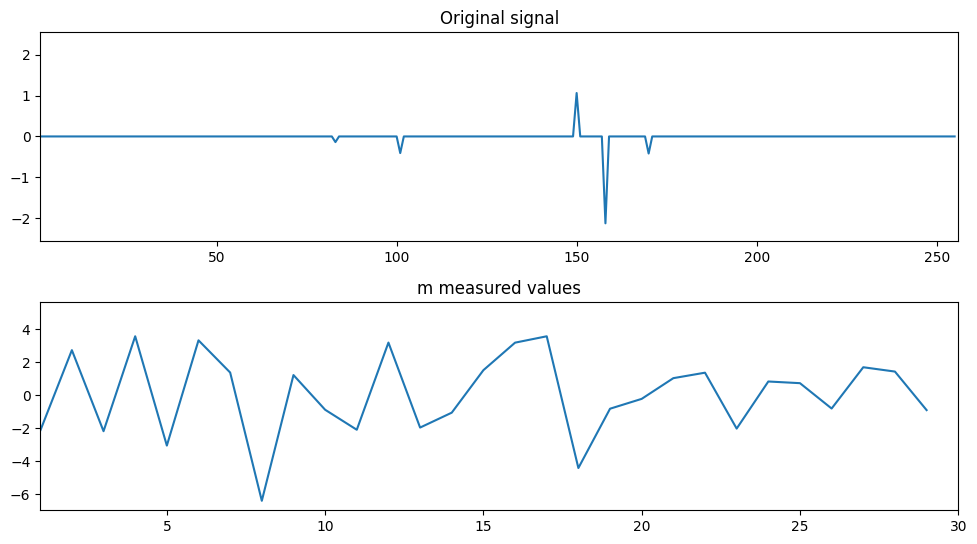

In [ ]:
# Initialize constants and variables
np.random.seed(0)  # Set RNG seed
N = 256             # Length of signal
P = 5               # Number of non-zero peaks
m = 30              # Number of measurements to take (m < N)

# Generate signal with P randomly spread values
x = np.zeros(N)  # Original signal (P-sparse)
peaks = np.random.permutation(N)[:P]  # Randomly select P indices
x[peaks] = np.random.randn(P)  # Assign random values at those indices

# Plot the original signal
amp = 1.2 * np.max(np.abs(x))
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(x)
plt.title('Original signal')
plt.xlim([1, N])
plt.ylim([-amp, amp])

# Obtain m measurements
A = np.random.randn(m, N)  # Measurement matrix
y = A @ x  # Matrix multiplication to obtain measurements
y = np.reshape(y,(m,1))

# Plot measured values
plt.subplot(3, 1, 2)
plt.plot(y)
plt.title('m measured values')
plt.xlim([1, m])

# Show the plots
plt.tight_layout()
plt.show()

Perform Compressed Sensing recovery

In [ ]:
# --------------------------------------------
# Simple algorithm - projected subgradient method
# ---------------------------------------------
max_iter = 1000
n = N
# Pre-computation
A_dagger = np.linalg.pinv(A)
x_tilde = np.dot(A_dagger, y)  # x_tilde = pinv(A) * y
Gamma = np.eye(n) - np.dot(A_dagger, A)  # Gamma = I - pinv(A) * A
xp = np.zeros((n, 1))  # Initialize xp
lossfun = np.zeros(max_iter + 1)

# Use a for loop with tqdm for progress tracking
for t in tqdm(range(max_iter + 1), desc="Iterations"):
    # Update x
    xp = x_tilde + np.dot(Gamma, (xp - (1 / (t + 1)) * np.sign(xp)))

    # Loss function
    lossfun[t] = np.linalg.norm(xp, 1)  # L1 norm

Iterations: 100%|██████████| 1001/1001 [00:00<00:00, 20318.23it/s]


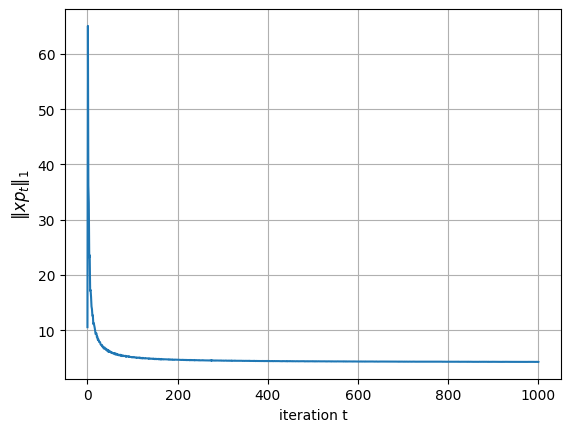

In [ ]:
# --------------------------------------------
# Post-processing
# ---------------------------------------------

plt.figure()
plt.plot(lossfun)
plt.xlabel('iteration t')
plt.ylabel(r'$\|xp_t\|_1$', fontsize=12)
plt.grid(True)
plt.show()

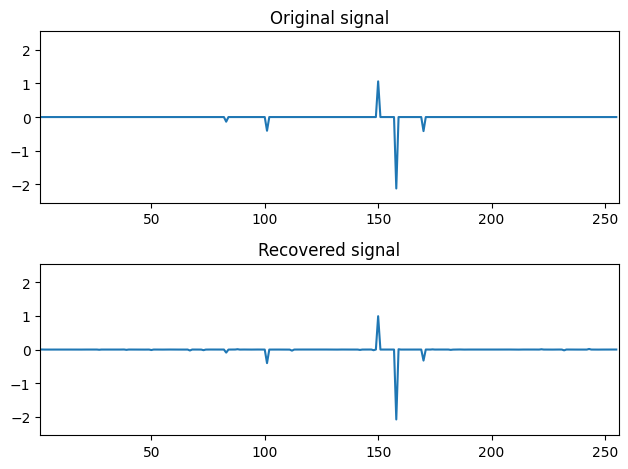

In [ ]:
# Plot the recovered signal
plt.subplot(2, 1, 1)
plt.plot(x)
plt.title('Original signal')
plt.xlim([1, N])
plt.ylim([-amp, amp])


plt.subplot(2, 1, 2)
plt.plot(np.real(xp))  # Plot the real part of the recovered signal
plt.title('Recovered signal')
plt.xlim([1, N])
plt.ylim([-amp, amp])

# Show the plots
plt.tight_layout()
plt.show()

## Section 1.2 - A sparse frequency-domain signal

Sometimes the signal we are interested in isn't sparse in the domain we've measured it in. For example, consider a signal composed of a small number of sinusoids. In the time domain the function sin(2πt) is not sparse. However, if we observe it in the frequency domain, it is fully represented by only two peaks

In order to perform recovery in the sparse domain, we must explicitly implement it this way. In order to do so, it is important to understand the two orthonormal bases (or orthobases) which are critical for CS.

Ψ - Representation basis

As mentioned several times already, our signal must be sparse in order to perform compressed sensing. The representation basis Ψ is the mathematical way of getting the signal into a sparse domain.

In Example 1, the time-domain signal was already in its sparse domain. Hence, Ψ was simply the identity matrix $I_N$, and could be excluded from in the algebra steps. However, in Example 2 below, we will have a time-domain signal that is sparse in a different domain (the frequency domain in this case). Therefore, Ψ will be the basis which transforms a time-domain signal into the frequency domain, i.e. the DFT matrix.

There are many possibilities for Ψ, and picking the right one is dependent on the application at hand. For frequency-sparse signals, the DFT is applicable. For 2-D images, however, one of the many Wavelet transform bases may be applicable, or the 2-D discrete cosine transform.

Φ - Sensing basis

The sensing basis Φ represents the domain from which we extract values from the signal. In Example 1, this was simply the matrix of random Gaussian entries. In Example 2 below, this will be spikes. As you can see, this describes the method used to obtain a smaller (compressed) amount of data. In Examples 1 and 2, this operation appears in two steps:

Create a random permutation with N values. (There are two randperms in Example 2, be sure to locate the correct one).
Grab the first K values, ensuring we've obtained K subsets of Φ at random.
Additional information

We have been treating our resulting K×N matrix (e.g. A from Exercise 1) as the sensing basis for simplicity. However, to be precise, the sensing basis is actually the complete N×N matrix, and an additional matrix R is used to extract the K entries from Φ. The extraction matrix is obtained by simply keeping K rows from $I_N$.

Thus, the sensing matrix in its complete form is A = RΦΨ.

The effect this has on our code is that the recovered data will not be in our original domain. It's in the compressed domain, and thus must be "uncompressed" by multiplying it by Ψ^{-1}. This returns the data to the desired domain.

A few notes before the code:

You can easily perform this same example by generating a set number of spikes in the frequency domain instead of generating time-domain signals first. The advantage of the method below is that it makes it easier to use real-valued time domain signals to more accurately represent real-life signals.

Because Ψ is the DFT matrix in this case, its inverse is easily obtainable as conj(Ψ)/N

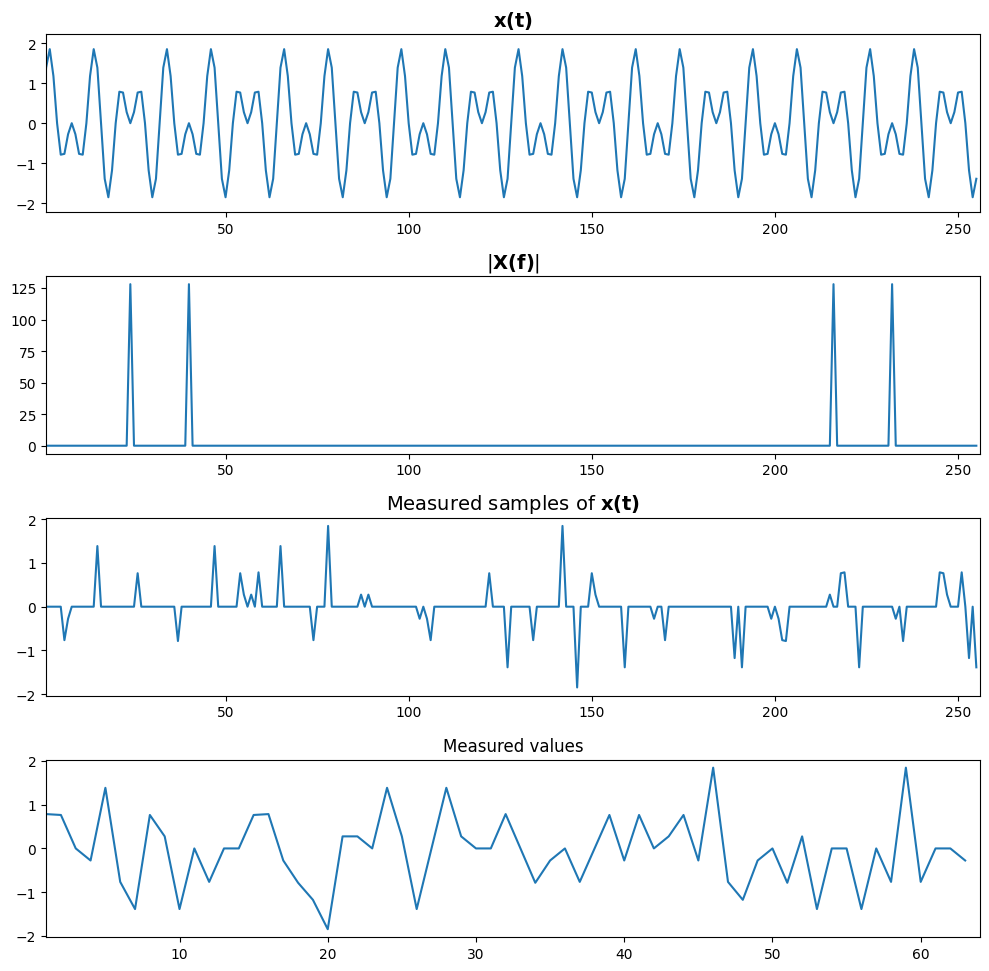

In [ ]:
# Initialize constants and variables
np.random.seed(0)  # Set RNG seed
N = 256             # Length of signal
P = 2               # Number of sinusoids
K = 64              # Number of measurements to take (N < L)

# Generate signal with P randomly spread sinusoids
# Note that a real-valued sinusoid has two peaks in the frequency domain
freq = np.random.permutation(N // 2)[:P]  # Randomly select P frequencies
n = np.arange(N)  # Time indices
x = np.sum(np.sin(2 * np.pi * freq[:, np.newaxis] / N * n), axis=0)  # Sum of sinusoids

# Orthonormal basis matrix (DFT matrix)
Psi = np.fft.fft(np.eye(N))  # DFT matrix
Psi_inv = np.conj(Psi) / N  # Inverse DFT matrix

# FFT of x(t)
X = Psi @ x  # Matrix multiplication to get DFT of x

# Plot signals
amp = 1.2 * np.max(np.abs(x))
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)
plt.plot(x)
plt.xlim([1, N])
plt.ylim([-amp, amp])
plt.title(r'$\mathbf{x(t)}$', fontsize=14)

plt.subplot(5, 1, 2)
plt.plot(np.abs(X))
plt.xlim([1, N])
plt.title(r'$|\mathbf{X(f)}|$', fontsize=14)

# Obtain K measurements
x_m = np.zeros(N)  # Initialize measured samples
q = np.random.permutation(N)[:K]  # Randomly select K indices
x_m[q] = x[q]  # Assign measured values

plt.subplot(5, 1, 3)
plt.plot(np.real(x_m))
plt.xlim([1, N])
plt.title(r'Measured samples of $\mathbf{x(t)}$', fontsize=14)

# Sensing matrix
A = Psi_inv[q, :]  # Select rows for the sensing matrix
y = A @ X  # Measured values
y = np.reshape(y,(K,1))

# Plotting the measured values
plt.subplot(5, 1, 4)
plt.plot(y)
plt.title('Measured values')
plt.xlim([1, K])

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Perform Compressed Sensing recovery

In [ ]:
# --------------------------------------------
# Simple algorithm - projected subgradient method
# ---------------------------------------------
max_iter = 100000*50
n = N

# Pre-computation
A_dagger = np.linalg.pinv(A)
x_tilde = np.dot(A_dagger, y)  # x_tilde = pinv(A) * y
Gamma = np.eye(n) - np.dot(A_dagger, A)  # Gamma = I - pinv(A) * A
# X_hat = np.zeros((n,1), dtype=complex)  # Initialize X_hat as a complex array
X_hat = np.dot(A.T, y)
lossfun = np.zeros(max_iter + 1)

# Custom sign function for complex numbers
def complex_sign(z):
    norm = np.abs(z)
    return np.where(norm != 0, z / norm, 0)  # Avoid division by zero

# Use a for loop with tqdm for progress tracking
for t in tqdm(range(max_iter + 1), desc="Iterations"):
    # Update x
    X_hat = x_tilde + np.dot(Gamma, (X_hat - (1 / (t + 1)) * complex_sign(X_hat)))

    # Loss function
    lossfun[t] = np.linalg.norm(X_hat, 1)  # L1 norm

Iterations: 100%|██████████| 5000001/5000001 [11:05<00:00, 7517.55it/s]


In [ ]:
np.linalg.norm(A@X_hat-y)

2.5510261853054496e-15

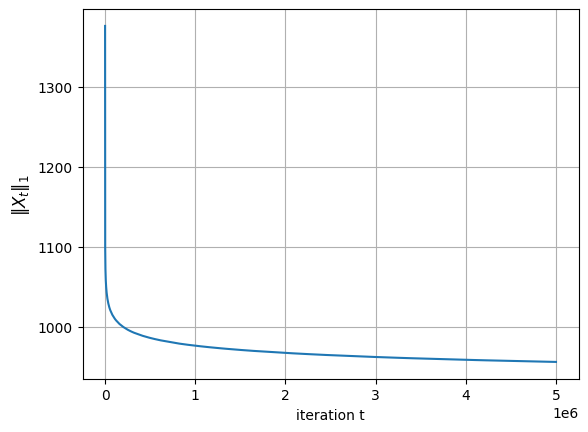

In [ ]:
# --------------------------------------------
# Post-processing
# ---------------------------------------------

plt.figure()
plt.plot(lossfun)
plt.xlabel('iteration t')
plt.ylabel(r'$\|X_t\|_1$', fontsize=12)
plt.grid(True)
plt.show()

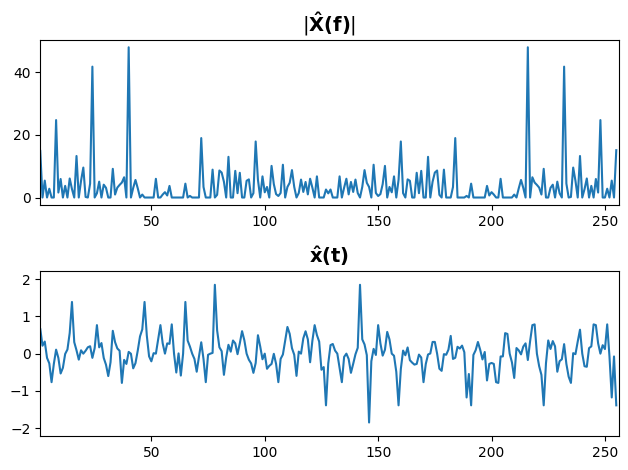

In [ ]:
# Plot the magnitude of X_hat
plt.subplot(2, 1, 1)
plt.plot(np.abs(X_hat))
plt.xlim([1, N])
plt.title(r'$|\mathbf{\hat{X}(f)}|$', fontsize=14)

# IFFT of X_hat(f) to get x_hat
x_hat = np.real(Psi_inv @ X_hat)  # Matrix multiplication for IFFT

# Plot the reconstructed time domain signal x_hat
plt.subplot(2, 1, 2)
plt.plot(x_hat)
plt.xlim([1, N])
plt.ylim([-amp, amp])
plt.title(r'$\mathbf{\hat{x}(t)}$', fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()

It goes in the good direction but the projected subgradient method is too slow,
More advanced methods should be considered, for instance the methods from Candes : https://candes.su.domains/software/l1magic/

Move to MatLab
- Download the l1magic.zip from candes's webiste, or from here
https://www.dropbox.com/scl/fo/kjhq8ay70ddazacdjp8my/AIljdbxAJGAZFXTJiFUSWIg?rlkey=g6qfkqwb9bv56w9ifb2byuwxv&st=jrcuzg94&dl=0
-  extract it
- Download the file "script_CS.m": https://www.dropbox.com/scl/fo/kjhq8ay70ddazacdjp8my/AIljdbxAJGAZFXTJiFUSWIg?rlkey=g6qfkqwb9bv56w9ifb2byuwxv&st=jrcuzg94&dl=0

Put it in the main directory to be able to call the routines from "Optimization" folder, in particular "1eq_pd.m" (which call also "cgsolve.m")
- run script_CS.m

# Section 2 - Compressed Sensing - Example 1 (DCT)

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct
from PIL import Image
from skimage.color import rgb2gray
from skimage import data

In [ ]:
images = (
'astronaut',
'binary_blobs',
'brick',
'colorwheel',
'camera',
'cat',
'checkerboard',
'clock',
'coffee',
'coins',
'eagle',
'grass',
'gravel',
'horse',
'logo',
'page',
'text',
'rocket',
)


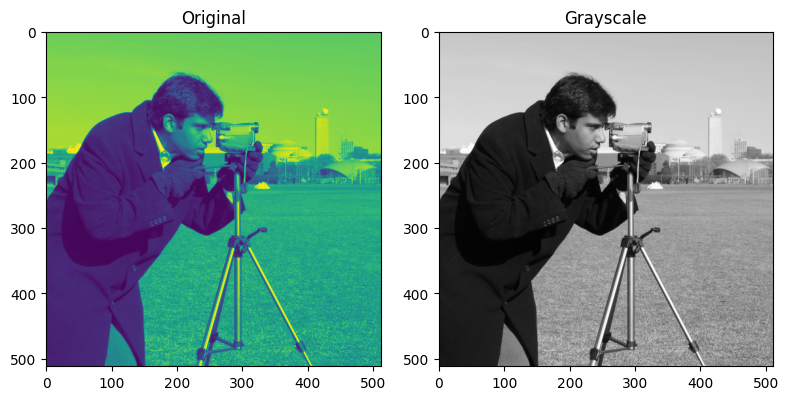

In [ ]:
# We select the "camera" image
caller = getattr(data, 'camera')
original = caller()
# Then we convert it in grayscale if needed, otherwise no
# grayscale = rgb2gray(original)
grayscale = original
# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
fig.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------
# Data generation
# ---------------------------------------------

# Load the image and convert to double
x_bar = np.matrix(grayscale)/ 255.0  # Normalize to [0, 1]
x = dct(x_bar, axis=0, norm='ortho')  # DCT along columns and rows
x_bar_o = x_bar.copy()  # Original image for later comparison

In [ ]:
# Generate Psi - Discrete Cosine Transform matrix (many real signals are globally sparse in this representation)
n = x.shape[0]
Psi = dct(np.eye(n), axis=0, norm='ortho')  # DCT matrix

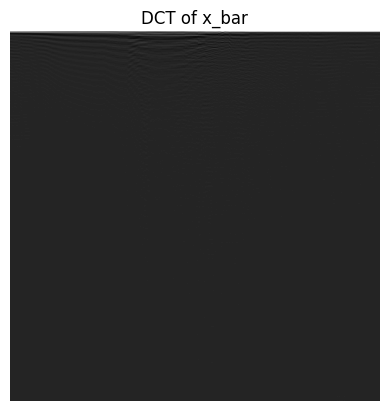

In [ ]:
# Visualisation DCT of x_bar
plt.figure()
plt.imshow(x, cmap='gray')
plt.title('DCT of x_bar')
plt.axis('off')
plt.show()

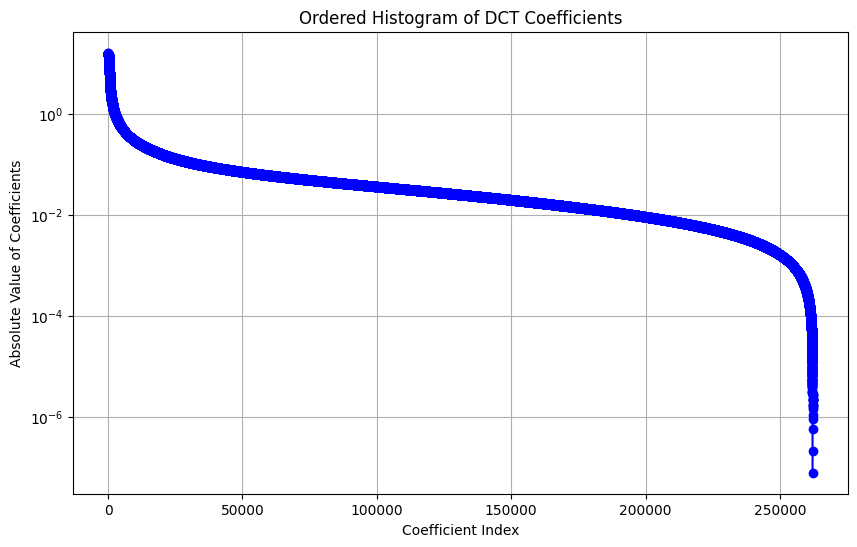

In [ ]:
# Get the absolute values of the coefficients
abs_x = np.abs(x.flatten())  # Flatten the array to 1D

# Sort the absolute values in descending order
sorted_abs_x = np.sort(abs_x)[::-1]

# Plotting the ordered histogram
plt.figure(figsize=(10, 6))
plt.plot(sorted_abs_x, marker='o', linestyle='-', color='b')
plt.title('Ordered Histogram of DCT Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Absolute Value of Coefficients')
plt.yscale('log')  # Log scale for better visibility
plt.grid(True)
plt.show()

In [ ]:
# Sparsify x (if needed)
thres = 0.1 # Adapt the threshold to make yourself in a more "sparse signal" setting
list_indices = np.where(np.abs(x) <= thres)
x[list_indices] = 0  # Thresholding
x_bar = np.dot(Psi.T, x)  # Reconstruct sparsified signal
print("Percentage of coeff removed with the thres: ", len(list_indices[0])/(n*n)*100 )

Percentage of coeff removed with the thres:  87.34893798828125


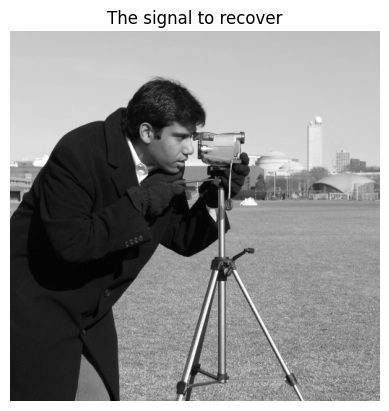

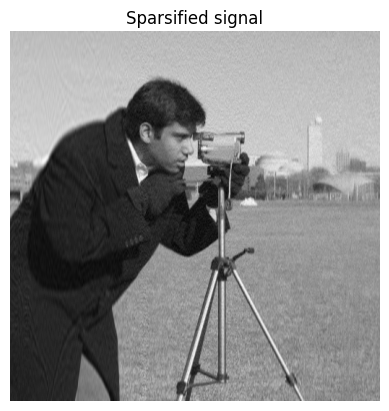

In [ ]:
plt.figure()
plt.imshow(x_bar_o, cmap='gray')
plt.title('The signal to recover')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(x_bar, cmap='gray')
plt.title('Sparsified signal')
plt.axis('off')
plt.show()


In [ ]:
m = 256  # m play with this
Phi = np.random.rand(m, n)  # Random projection matrix
A = np.dot(Phi, Psi.T)  # A = Phi * Psi^T
y = np.dot(Phi, x_bar)  # y = Phi * x_bar

In [ ]:
# --------------------------------------------
# Simple algorithm - projected subgradient method
# ---------------------------------------------

max_iter = 1000

# Pre-computation
A_dagger = np.linalg.pinv(A)
x_tilde = np.dot(A_dagger, y)  # x_tilde = pinv(A) * y
Gamma = np.eye(n) - np.dot(A_dagger, A)  # Gamma = I - pinv(A) * A
x = np.zeros((n, n))  # Initialize x
lossfun = np.zeros(max_iter + 1)

# Use a for loop with tqdm for progress tracking
for t in tqdm(range(max_iter + 1), desc="Iterations"):
    # Update x
    x = x_tilde + np.dot(Gamma, (x - (1 / (t + 1)) * np.sign(x)))

    # Loss function
    lossfun[t] = np.linalg.norm(x, 1)  # L1 norm

Iterations: 100%|██████████| 1001/1001 [00:15<00:00, 66.56it/s]


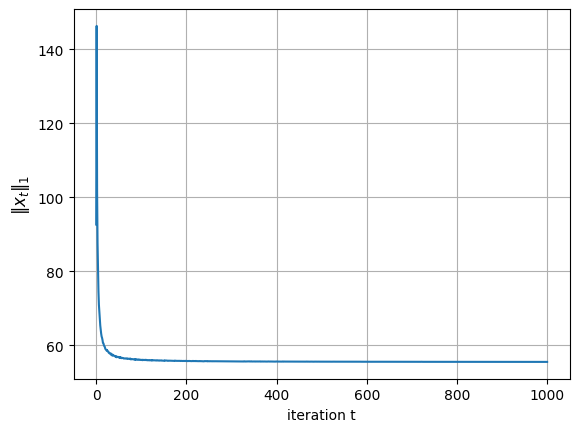

In [ ]:
# --------------------------------------------
# Post-processing
# ---------------------------------------------

plt.figure()
plt.plot(lossfun)
plt.xlabel('iteration t')
plt.ylabel(r'$\|x_t\|_1$', fontsize=12)
plt.grid(True)
plt.show()

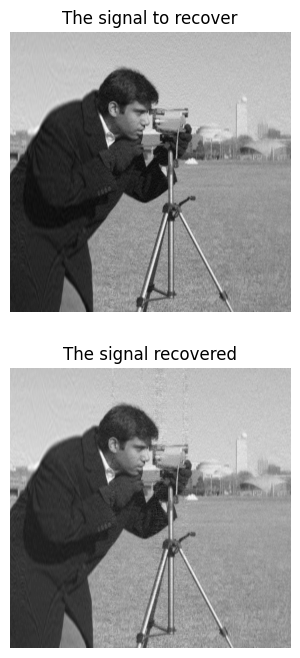

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.imshow(x_bar, cmap='gray')
plt.title('The signal to recover')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(np.dot(Psi.T, x), cmap='gray')  # Reconstruct the image
plt.title('The signal recovered')
plt.axis('off')
plt.show()

In [ ]:
# If poor quality, increase m values for Phi

# Section 3 - Compressed Sensing - more advanced

from here https://humaticlabs.com/blog/compressed-sensing-python/

To consider:
- "Reconstruction of an Image (a 2D Signal)" - investigate if this can be done in matrix updates such as in Section 2, or if vectorization is necessary
- Optimization and Scalability  - L-BFGS algorithm should be considered. PyLBFGS (https://bitbucket.org/rtaylor/pylbfgs/src/master/) for a good Python implementation.